# Emotion Classification

## 1. Google Drive Mount & Image Datasets Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- You can download FER(Face Emotions Recognition) Datasets from https://www.kaggle.com/datasets/msambare/fer2013

In [2]:
import zipfile

path = '/content/drive/MyDrive/colab/Computer-Vision-Course/Data/Datasets/fer_images.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

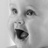

In [3]:
import tensorflow as tf

tf.keras.preprocessing.image.load_img('/content/fer2013/train/Happy/100.jpg')

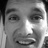

In [4]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Surprise/100.jpg')

In [5]:
import numpy as np

img = tf.keras.preprocessing.image.load_img('/content/fer2013/train/Neutral/100.jpg')
np.array(img).shape

(48, 48, 3)

## 2. Create Train and Test Datasets

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=10,  # Degree range for random rotations
                                     zoom_range=0.2,  # Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
                                     horizontal_flip=True,  # Randomly flip inputs horizontally
                                     rescale=1/255)  # Rescaling by 1/255 to normalize

- `ImageDataGenerator()` generates batches of tensor image data with real-time data augmentation. (Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
 - `rotation_range`, `zoom_range`, `horizontal_flip` are parameters for data augmentation
 - `rescale` is a parameter for normalization



In [7]:
train_dataset = train_generator.flow_from_directory(directory='/content/fer2013/train',
                                                    target_size=(48, 48),  # Tuple of integers (height, width), defaults to (256, 256)
                                                    class_mode='categorical',
                                                    batch_size=16,  # Size of the batches of data (default: 32)
                                                    shuffle=True,  # Whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order
                                                    seed=10) 

Found 28709 images belonging to 7 classes.


- `flow_from_directory()` takes the path to a directory & generates batches of augmented data.

In [8]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [9]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [10]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

- 436 images corresponding to Disgust are relatively small.

In [11]:
test_generator = ImageDataGenerator(rescale=1/255)

test_dataset = test_generator.flow_from_directory(directory='/content/fer2013/validation',
                                                  target_size=(48, 48),
                                                  class_mode='categorical',
                                                  batch_size=1,
                                                  shuffle=False,
                                                  seed=10)

Found 3589 images belonging to 7 classes.


- The reason why `batch_size=1` is because we're going to test it one by one.

## 3. Build Convolutional Neural Network(CNN)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

num_classes = 7
num_detectors = 32
width, height = 48, 48

network = Sequential()

network.add(Conv2D(filters=num_detectors, kernel_size=3, activation='relu', padding='same', input_shape=(width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(filters=num_detectors, kernel_size=3, activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, 3, activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, 3, activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, 3, activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, 3, activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, 3, activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, 3, activation='relu', padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2, 2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2*2*num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2*num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))

In [13]:
print(network.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

## 4. Train the Model

In [14]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
epochs = 70

network.fit(train_dataset, epochs=epochs)

Epoch 1/70
1795/1795 [==============================] - 76s 33ms/step - loss: 1.8536 - accuracy: 0.2625
Epoch 2/70
1795/1795 [==============================] - 59s 33ms/step - loss: 1.5566 - accuracy: 0.3928
Epoch 3/70
1795/1795 [==============================] - 56s 31ms/step - loss: 1.3949 - accuracy: 0.4650
Epoch 4/70
1795/1795 [==============================] - 58s 32ms/step - loss: 1.3160 - accuracy: 0.5007
Epoch 5/70
1795/1795 [==============================] - 57s 32ms/step - loss: 1.2652 - accuracy: 0.5247
Epoch 6/70
1795/1795 [==============================] - 57s 32ms/step - loss: 1.2193 - accuracy: 0.5413
Epoch 7/70
1795/1795 [==============================] - 57s 32ms/step - loss: 1.1857 - accuracy: 0.5542
Epoch 8/70
1795/1795 [==============================] - 55s 31ms/step - loss: 1.1572 - accuracy: 0.5668
Epoch 9/70
1795/1795 [==============================] - 56s 31ms/step - loss: 1.1281 - accuracy: 0.5813
Epoch 10/70
1795/1795 [==============================] - 57s 32m

## 5. Save & Load the Model

- If you want to save & load the model/weights uncomment below code.

In [16]:
# from keras.models import save_model

# # Save the trained network json
# with open('trained_network.json', 'w') as trained_network_json:
#     trained_network_json.write(network.to_json())

# # Load the trained network json
# with open('trained_network.json', 'r') as trained_network_json:
#     trained_model_json = trained_network_json.read()

# # Save weights
# save_model(network, '/content/weights_emotions.hdf5')

# # Load the trained model & weights
# network = tf.keras.models.model_from_json(trained_model_json)
# network.load_weights('/content/weights_emotions.hdf5')
# network.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## 6. Evaluate the Model

In [17]:
network.evaluate(test_dataset)

3589/3589 [==============================] - 21s 6ms/step - loss: 1.5031 - accuracy: 0.5784


[1.5030847787857056, 0.5784341096878052]

In [18]:
preds = network.predict(test_dataset)
preds

3589/3589 [==============================] - 16s 4ms/step


array([[8.3438432e-01, 5.6078522e-03, 2.8129719e-02, ..., 2.4448015e-02,
        9.9659674e-02, 7.7695400e-03],
       [9.7052783e-01, 2.2957376e-04, 2.8516585e-02, ..., 1.2031295e-05,
        5.7170750e-04, 1.3691060e-04],
       [9.9428201e-01, 5.5973549e-05, 1.5214941e-03, ..., 2.8439015e-03,
        7.2422280e-04, 1.6453549e-04],
       ...,
       [1.0237281e-03, 5.9235331e-06, 1.1370340e-01, ..., 2.0720935e-03,
        3.1136530e-03, 8.8008118e-01],
       [1.1418144e-03, 1.8816721e-05, 5.0142910e-02, ..., 1.2533104e-02,
        1.7909543e-03, 9.3436068e-01],
       [1.6623830e-03, 5.5997980e-06, 4.4663671e-02, ..., 1.7143032e-03,
        3.2607825e-03, 9.4129729e-01]], dtype=float32)

In [19]:
preds = np.argmax(preds, axis=1)
preds

array([0, 0, 0, ..., 6, 6, 6])

In [20]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(test_dataset.classes, preds)

0.5784341042073001

In [22]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

## 7. Classify with Real Image

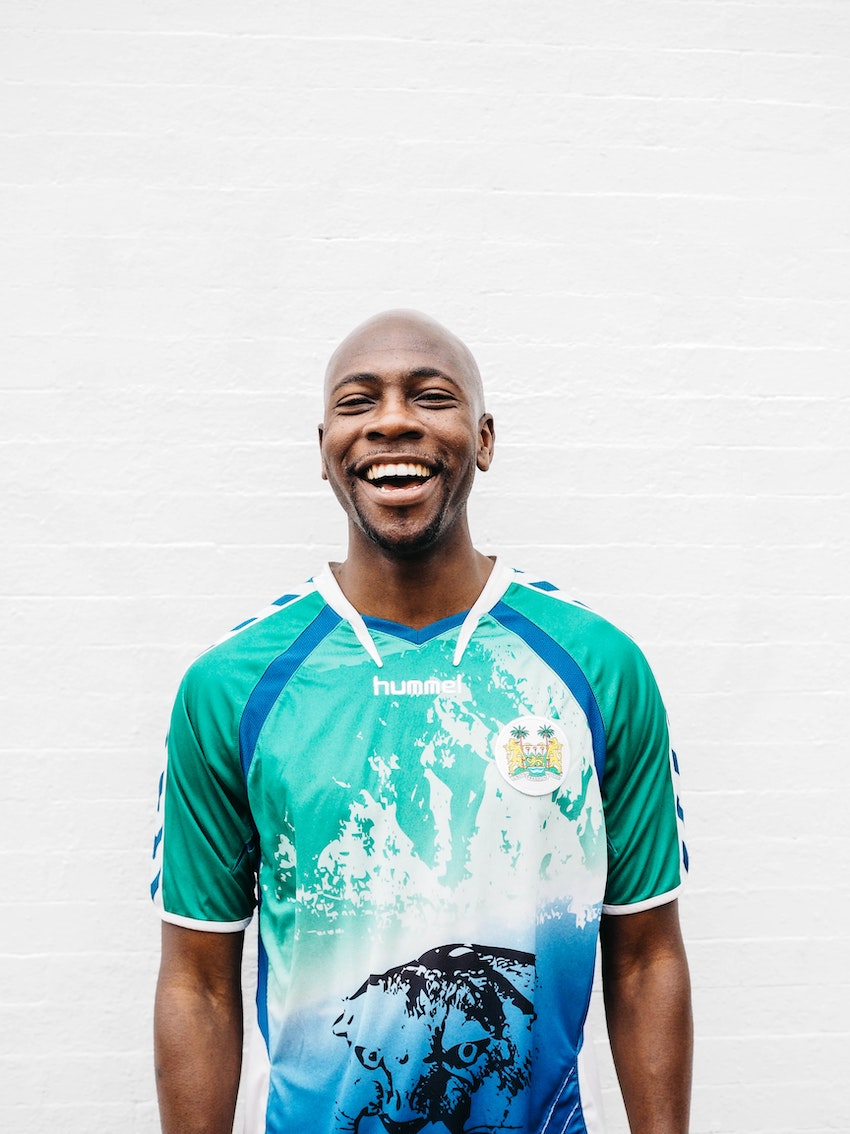

In [47]:
import cv2
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/drive/MyDrive/colab/Computer-Vision-Course/Data/Images/happy_face2.jpg')

cv2_imshow(image)

In [48]:
import dlib
face_detector = dlib.cnn_face_detection_model_v1('/content/drive/MyDrive/colab/Computer-Vision-Course/Data/Weights/mmod_human_face_detector.dat')

face_detection = face_detector(image, 1)
face_detection

mmod_rectangles[[(315, 359) (457, 500)]]

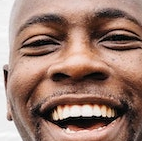

In [49]:
left, top, right, bottom = face_detection[0].rect.left(), face_detection[0].rect.top(), face_detection[0].rect.right(), face_detection[0].rect.bottom()

roi = image[top:bottom, left:right]

cv2_imshow(roi)

In [50]:
roi.shape

(141, 142, 3)

In [51]:
# Resize image
roi = cv2.resize(roi, (48, 48))

roi.shape

(48, 48, 3)

In [52]:
# Normalize
roi = roi / 255

In [54]:
roi = np.expand_dims(roi, axis=0)
roi.shape

(1, 48, 48, 3)

In [55]:
pred_probability = network.predict(roi)
pred_probability

1/1 [==============================] - 0s 23ms/step


array([[1.6061535e-01, 1.4578884e-04, 1.8617315e-02, 7.9159176e-01,
        2.1857673e-02, 5.3516589e-03, 1.8204855e-03]], dtype=float32)

In [56]:
pred = np.argmax(pred_probability)
pred

3